<a href="https://colab.research.google.com/github/adowaconan/Deep_learning_fMRI/blob/master/5_1_How_to_represent_experiment_stimuli_via_word2vec_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Make sure change runtime type to python2:

1. click "Runtime"
2. click "Change run time type"
3. select "python 2"
4. optional: select GPU support

## Given the size of a word2vec model, it will take a long to load the model from my Google Drive (where it is shared) to your Google Colab workspace

In [1]:
!pip install -U -q PyDrive
!pip install tqdm
!apt-get install swig
!pip install -U pymvpa2
!pip install -U seaborn

# this lets you access to googel drive shared files
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)


stimuli_table_id = 'https://drive.google.com/open?id=1cVQXOhkaUYRJWgy65Zb1WQh0YJLEOAmH'.split('id=')[-1]
word2vec_model_id = 'https://drive.google.com/open?id=1Dj9aTqHbuknWZC9kQJabqH3NqGXe_PT4'.split('id=')[-1]

stimuli_ = drive.CreateFile({'id':stimuli_table_id})
word2vec_model_ = drive.CreateFile({'id':word2vec_model_id})

stimuli_.GetContentFile('{}'.format('definitions.txt'))
word2vec_model_.GetContentFile('{}'.format('glove-sbwc.i25.vec'))

Reading package lists... Done
Building dependency tree       
Reading state information... Done
swig is already the newest version (3.0.12-1).
0 upgraded, 0 newly installed, 0 to remove and 13 not upgraded.
Requirement already up-to-date: pymvpa2 in /usr/local/lib/python2.7/dist-packages (2.6.5)
Requirement already up-to-date: seaborn in /usr/local/lib/python2.7/dist-packages (0.9.0)


# The python libraries we will need

1. numpy: numerical python
2. pandas: table
3. tqdm: progress bar
4. **gensim**: need for loading word2vec models
5. scipy.spatial.distance: representational dissimilarity matrix
6. MinMaxScaler: rescale features to between 0 and 1
7. LinearSVC: a selected linear classifier
8. roc_auc_score: a selected scoring method, good for balanced or unbalanced data
9. CalibratedClassifierCV: a classifier wrapper for providing probabilistic predictions
10. MultiOutputClassifier: a classifier wrapper for decoding if target is more than 1-D
11. model_selection: CV method
12. seaborn (better in 0.9.0 version): pretty plotting

In [0]:
import numpy as np
import pandas as pd
from tqdm import tqdm
from matplotlib import pyplot as plt
from gensim.models.keyedvectors import KeyedVectors # for loading word2vec models
from scipy.spatial import distance
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.pipeline import make_pipeline
from sklearn.metrics import roc_auc_score
from sklearn.calibration import CalibratedClassifierCV
from sklearn.multioutput import MultiOutputClassifier
from sklearn.model_selection import StratifiedShuffleSplit,LeavePGroupsOut
import seaborn as sns
sns.set_style('white')
sns.set_context('poster')

# some essential parameters and loadings

In [0]:
n_splits = 3000

In [4]:
# candidate model
Glove_from_SBWC = 'glove-sbwc.i25.vec'
# load the stimuli table
stimuli_table = pd.read_csv('definitions.txt', sep='\t')
print('loading Glove model, and it is going to take some time...')
model_glove = KeyedVectors.load_word2vec_format(Glove_from_SBWC)

loading Glove model, and it is going to take some time...


# Let's take a look at the experiment stimuli

In [0]:
def convert_labels_4(row):
    if (row['Condition'] == "TOM") and (row["Likableness"] == "pos"):
        return 1
    elif (row['Condition'] == "EMPA") and (row["Likableness"] == "pos"):
        return 2
    elif (row['Condition'] == "TOM") and (row["Likableness"] == "neg"):
        return 3
    elif (row['Condition'] == "EMPA") and (row["Likableness"] == "neg"):
        return 4

In [6]:
stimuli_table

,Concept,Definition,Condition,Likableness
0,Sincero,"Dice lo que piensa realmente, sin mentir ni fi...",TOM,pos
1,Comprensivo,Entiende el porqué del comportamiento de los d...,TOM,pos
2,Leal,Siempre actúa con respeto y fidelidad a sus co...,TOM,pos
3,Inteligente,"Sabe razonar, resolver problemas y comprender ...",TOM,pos
4,Generoso,Tiene inclinación a dar y compartir por encima...,TOM,pos
5,Ingenioso,Tiene capacidad para inventar cosas combinando...,TOM,pos
6,Cooperativo,Disfruta haciendo cosas y combinando esfuerzos...,TOM,pos
7,Indulgente,Tiende a perdonar las ofensas y juzgar sin sev...,TOM,pos
8,Concienzudo,Pone mucha atención y cuidado en todo lo que hace,TOM,pos
9,Farsante,Se hace pasar por alguien que no es para engañ...,TOM,neg


# Let's take a look at how word2vec represents a word: HOLA

In [7]:
model_glove['hola']

array([-0.193197,  0.706149,  0.049731,  0.013734,  0.1021  , -0.20085 ,
        0.20472 , -0.122732,  0.064032, -0.114455, -0.392483, -1.007342,
       -0.412572, -0.235347, -0.01291 , -0.345172, -0.01192 , -0.463723,
        0.173729, -0.005871,  0.58785 , -0.119699, -0.165383,  0.036525,
        0.051103,  0.029718, -0.036098,  0.854265, -0.350027,  0.292484,
        0.12365 ,  0.388437, -0.65227 , -0.594902,  0.472801, -0.093599,
        0.075674,  0.267353, -0.264011, -0.378799, -0.17186 ,  0.808544,
        0.332545,  0.120567, -0.02629 ,  0.132692,  0.02045 , -0.034724,
       -0.300301, -0.57767 , -0.3282  , -0.022394, -0.225345, -0.044118,
       -0.130263,  0.456858,  0.103402,  0.190423,  0.005027, -0.297897,
       -0.113446, -0.22622 ,  0.192993,  0.488046, -0.016434,  0.125289,
       -0.094397, -0.038665,  0.161327,  0.303266, -0.506951,  0.120308,
        0.070032,  0.253879,  0.514638, -0.262457, -0.125268,  0.096984,
        0.276991,  0.545272,  0.548508, -0.358179, 

In [8]:
print('word: ',stimuli_table['Concept'][0].lower())
model_glove.similar_by_word(stimuli_table['Concept'][0].lower())

('word: ', 'sincero')


/usr/local/lib/python2.7/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[(u'agradecimiento', 0.7150760889053345),
 (u'gratitud', 0.6644769906997681),
 (u'profundo', 0.6401612758636475),
 (u'aprecio', 0.6364169120788574),
 (u'honesto', 0.6254974603652954),
 (u'deseo', 0.6237819194793701),
 (u'expresar', 0.6178677082061768),
 (u'sincera', 0.6146620512008667),
 (u'agradecer', 0.6100949645042419),
 (u'sinceramente', 0.5814681649208069)]

# Transform the words to vectors

In [0]:
# now the loaded word2vec model can be used as a pythonic dictionary, for more details, read gensim documentation and its tutorial.
temp = np.array([model_glove[word.decode('utf-8').lower()] for word in stimuli_table['Concept']])
# this is for plotting the x/y tick labels
word2ticks = [word.decode('utf-8').lower() for word in stimuli_table['Concept']]

In [10]:
temp.shape,word2ticks

((36, 300),
 [u'sincero',
  u'comprensivo',
  u'leal',
  u'inteligente',
  u'generoso',
  u'ingenioso',
  u'cooperativo',
  u'indulgente',
  u'concienzudo',
  u'farsante',
  u'codicioso',
  u'maleducado',
  u'ego\xedsta',
  u'hostil',
  u'aburrido',
  u'prejuicioso',
  u'irresponsable',
  u'vago',
  u'emp\xe1tico',
  u'afable',
  u'bondadoso',
  u'animado',
  u'cari\xf1oso',
  u'entusiasta',
  u'agradecido',
  u'sensible',
  u'compasivo',
  u'cruel',
  u'insensible',
  u'condescendiente',
  u'despiadado',
  u'pesimista',
  u'resentido',
  u'neur\xf3tico',
  u'exaltado',
  u'envidioso'])

# A heatmap of the representational dissimilarity matrix of the words/concepts we used in the experiment

One motivation for removing the mean is to make the pattern analysis more 
    complementary to the regional-mean activation analysis, which many 
    researchers standardly also perform. Note that this motivation is at 
    odds with the desire to best emulate decoding results because most decoders,
    by default, will exploit regional-mean activation differences as well as 
    fine-grained pattern differences.

[Text(0.5,1,'RDM of GLOVE model')]

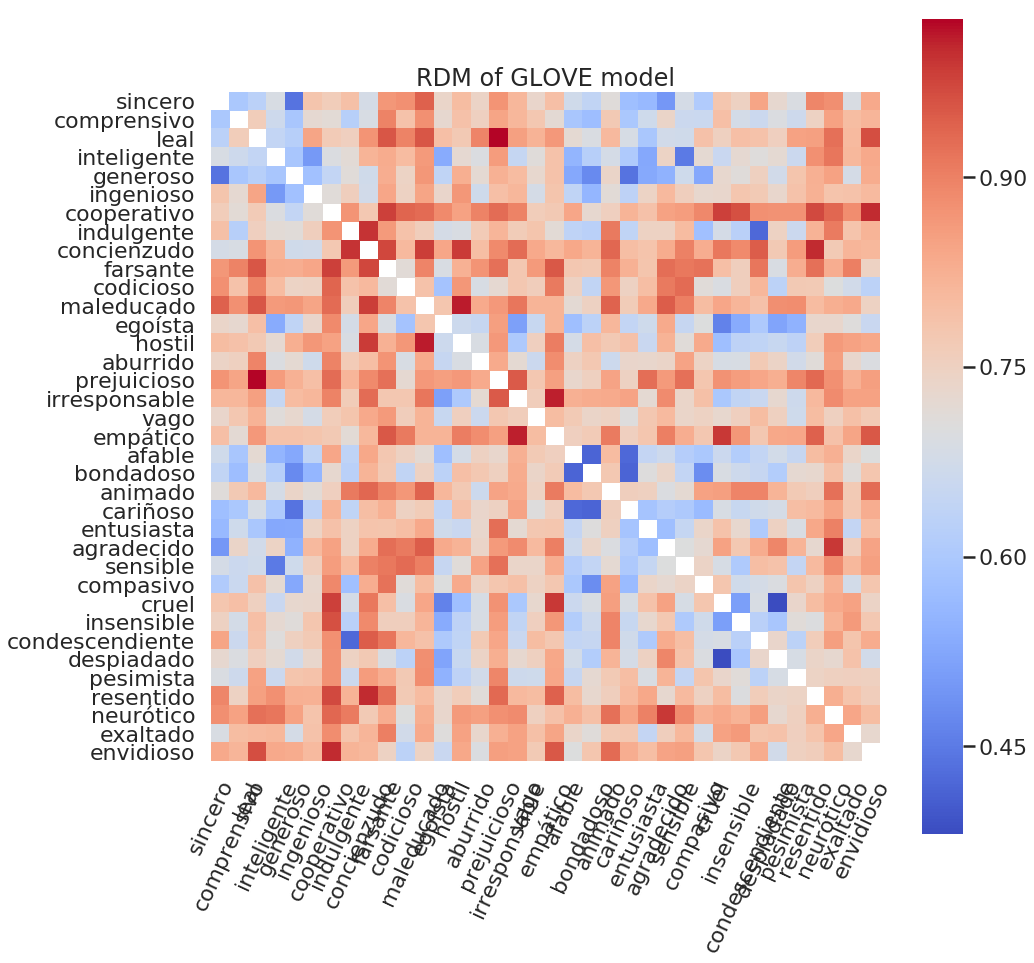

In [11]:
# heatmap of the word2vec model based on the concept
temp_s = (temp - temp.mean())#/temp.std()
RDM = distance.squareform(distance.pdist(temp_s,'cosine'))
np.fill_diagonal(RDM,np.nan)
fig,ax = plt.subplots(figsize=(15,15),)
ax = sns.heatmap(RDM,
                 cmap = plt.cm.coolwarm,
                 square = True,
                 ax = ax)
ax.set_xticks(np.arange(RDM.shape[0]))
#ax.set_xticklabels(np.arange(RDM.shape[0]))
ax.set_xticklabels(word2ticks,rotation = 65)
ax.set_yticklabels(word2ticks,rotation = 0)
ax.set(title='RDM of {} model'.format('GLOVE'))

# Look at the dissimilarity measure in terms of decoding instead of simple correlation

# Intuition:

- "RDMs are distance matrices whose entries reflect the separation in the representation of each pair of stimuli. We could use a linear classifier to estimate the discriminability of each pair of stimuli, and interpret these discriminabilities as our distances."" ([Nili et al. 2014](https://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1003553#pcbi.1003553.s004))
- We fomulate the discriminability of word1 (sincero) and word2 (envidioso) as the expected value of fitting a classifier using word1with many other words and then predict the category of word2:
$$\frac{1}{N} \sum_{i=1}^N [classifier.fit (\text{word}_1,\{\text{word}_i\}).predict(\text{word}_2) ]$$

- [representational similarity analyses using decoder accuracies and linear discriminability measures (LD-t, crossnobis) are widely used in the literature (Kriegeskorte et al. 2007, Nili et al. 2014, Cichy et al. 2014, Carlin et al. 2017 to name just a few)](https://nikokriegeskorte.org/category/representational-similarity-analysis/)


## So, how big the N should be?
- for 80-20 cross validation of 36 items, we will have around 7 items as the test set, leaving 29 items as the training set.
- so ideally, we want to have 7Cr36 (reads reandomly choose 7 items from 36 items, [combination](https://www.calculatorsoup.com/calculators/discretemathematics/combinations.php)), which is 8347680
- so practically, we perform 50000 if possible, 1000 if we don't have enough computational power.

In [0]:
# decoding the concepts based on the word2vec model of the concepts
from sklearn.preprocessing import LabelBinarizer
lb = LabelBinarizer()
# we want to predict theory of mind
condition = lb.fit_transform(stimuli_table['Condition'].values).flatten()
# we want to predict positive - negative as well
likableness = lb.fit_transform(stimuli_table['Likableness'].values).flatten()
# concatenate these 2 1-D vectors to generate a 2 X n_sample target matrix
labels = np.vstack([condition,likableness]).T
# features are the word2vec vectors
features = temp.copy()

# Decoding

In [13]:
cv = StratifiedShuffleSplit(n_splits,test_size=0.2,random_state=12345)
groups = np.arange(len(stimuli_table))
scores = []
for train,test in tqdm(cv.split(features,labels,groups=groups)):
    est = MultiOutputClassifier(CalibratedClassifierCV(LinearSVC(random_state = 12345)))
    clf = make_pipeline(StandardScaler(),
                        est)
    clf.fit(features[train],labels[train])
    preds = np.array(clf.predict_proba(features[test]))[:,:,-1]
    score = [roc_auc_score(a,b) for a,b in zip(labels[test].T,preds)]
    scores.append(score)
scores = np.array(scores)

0it [00:00, ?it/s]/usr/local/lib/python2.7/dist-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
3000it [01:23, 36.03it/s]


[Text(0.5,1,'Decode both Condition and Likableness by the concepts, MultiOutput Classification\nCV = 3000 folds, GLOVE model')]

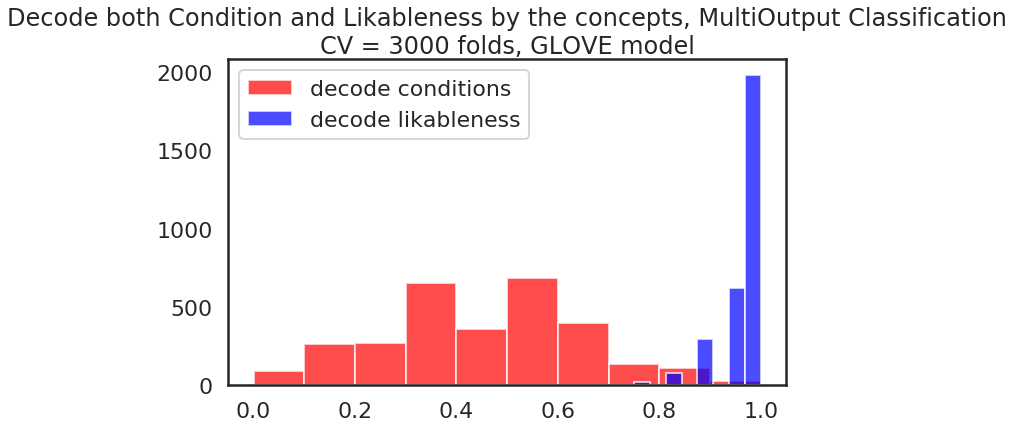

In [14]:
fig,ax = plt.subplots(figsize=(10,6))
ax.hist(scores[:,0],color='red',label='decode conditions',alpha=0.7,bins=10)
ax.hist(scores[:,1],color='blue',label='decode likableness',alpha=0.7,bins=10)
ax.legend()
ax.set(title = 'Decode both Condition and Likableness by the concepts, MultiOutput Classification\nCV = {} folds, {} model'.format(n_splits,'GLOVE'))

# let's look at the RDM above from a different perspective:
## if we train a classifier using part of the concepts, and then test the classfiier in the rest of the concepts, we will have a quasi-correspondence between words, train -> test
## so we can mark them down on a 36 by 36 matrix, and when we repeat this process for 1000 times, we will have 1000 of these relationships
## so, taking the average over the folds will give us an estimate of quasi-one-on-one relationship.

In [15]:
# decoding the concepts based on the word2vec model of the concepts
from sklearn.preprocessing import LabelBinarizer
lb = LabelBinarizer()
# we want to predict theory of mind
condition = lb.fit_transform(stimuli_table['Condition'].values).flatten()
# we want to predict positive - negative as well
likableness = lb.fit_transform(stimuli_table['Likableness'].values).flatten()
# concatenate these 2 1-D vectors to generate a 2 X n_sample target matrix
labels = np.vstack([condition,likableness]).T
cm_condition = np.ones((n_splits,features.shape[0],features.shape[0])) * np.nan
cm_likable = np.ones((n_splits,features.shape[0],features.shape[0])) * np.nan
cv = StratifiedShuffleSplit(n_splits,test_size = 0.2,random_state=12345)
for idx,(train,test) in tqdm(enumerate(cv.split(features,labels))):
    est = MultiOutputClassifier(CalibratedClassifierCV(LinearSVC(random_state = 12345)))
    clf = make_pipeline(StandardScaler(),
                        est)
    clf.fit(features[train],labels[train])
    preds = np.array(clf.predict_proba(features[test]))[:,:,-1]
    score = [roc_auc_score(a,b) for a,b in zip(labels[test].T,preds)]
    for idx_train in train:
        for idx_test in test:
            cm_condition[idx,idx_train,idx_test] = score[0]
            cm_likable[idx,idx_train,idx_test] = score[1]
            cm_condition[idx,idx_test,idx_train] = score[0]
            cm_likable[idx,idx_test,idx_train] = score[1]
cm_condition_mean = np.nanmean(cm_condition,0)
#np.fill_diagonal(cm_condition_mean, np.nan)
cm_likable_mean = np.nanmean(cm_likable,0)
#np.fill_diagonal(cm_likable_mean, np.nan)

3000it [01:24, 35.44it/s]
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:25: RuntimeWarning: Mean of empty slice
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:27: RuntimeWarning: Mean of empty slice


[Text(0.5,1,'RDM of GLOVE model from decoding condition by concepts')]

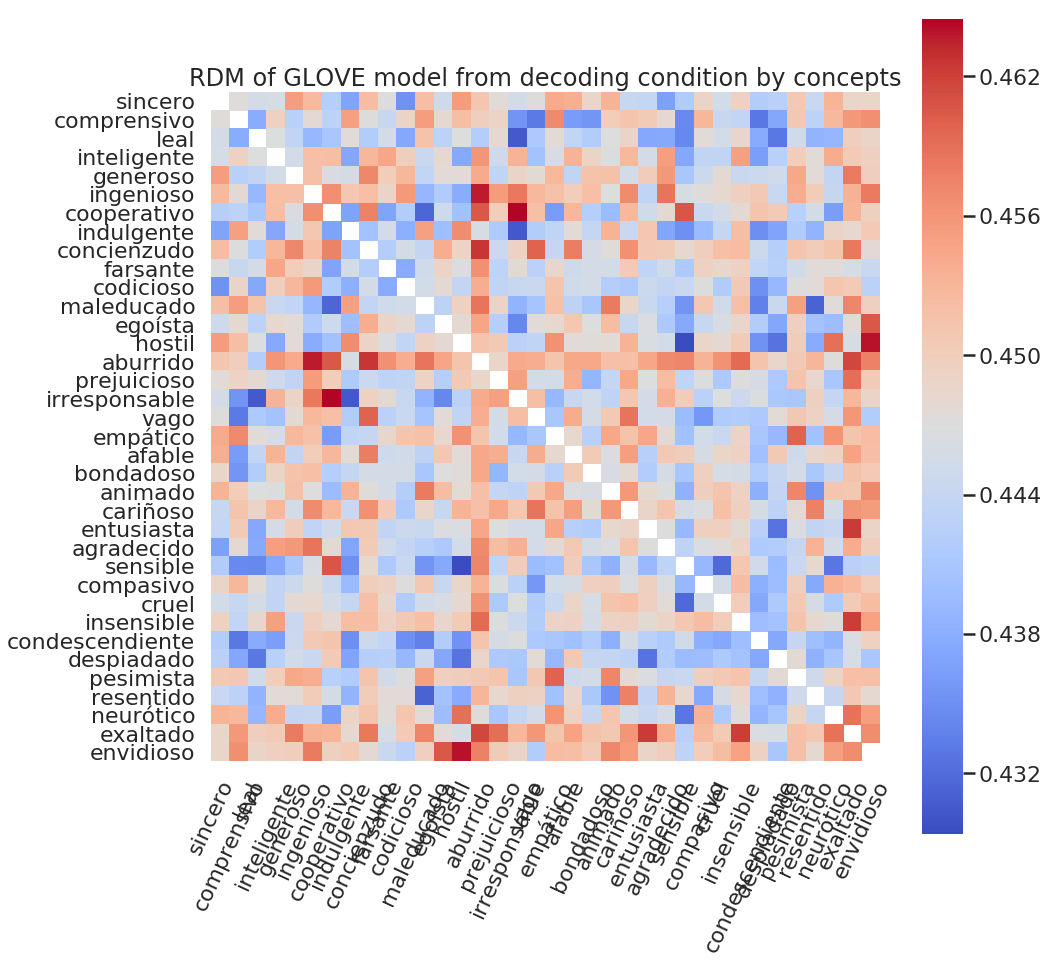

In [16]:
fig,ax = plt.subplots(figsize=(15,15),)
ax = sns.heatmap(cm_condition_mean,
                 cmap = plt.cm.coolwarm,
                 square = True,
                 ax = ax)
ax.set_xticks(np.arange(cm_condition_mean.shape[0]))
#ax.set_xticklabels(np.arange(RDM.shape[0]))
ax.set_xticklabels(word2ticks,rotation = 65)
ax.set_yticklabels(word2ticks,rotation = 0)
ax.set(title='RDM of {} model from decoding condition by concepts'.format('GLOVE'))

[Text(0.5,1,'RDM of GLOVE model from decoding likableness by concepts')]

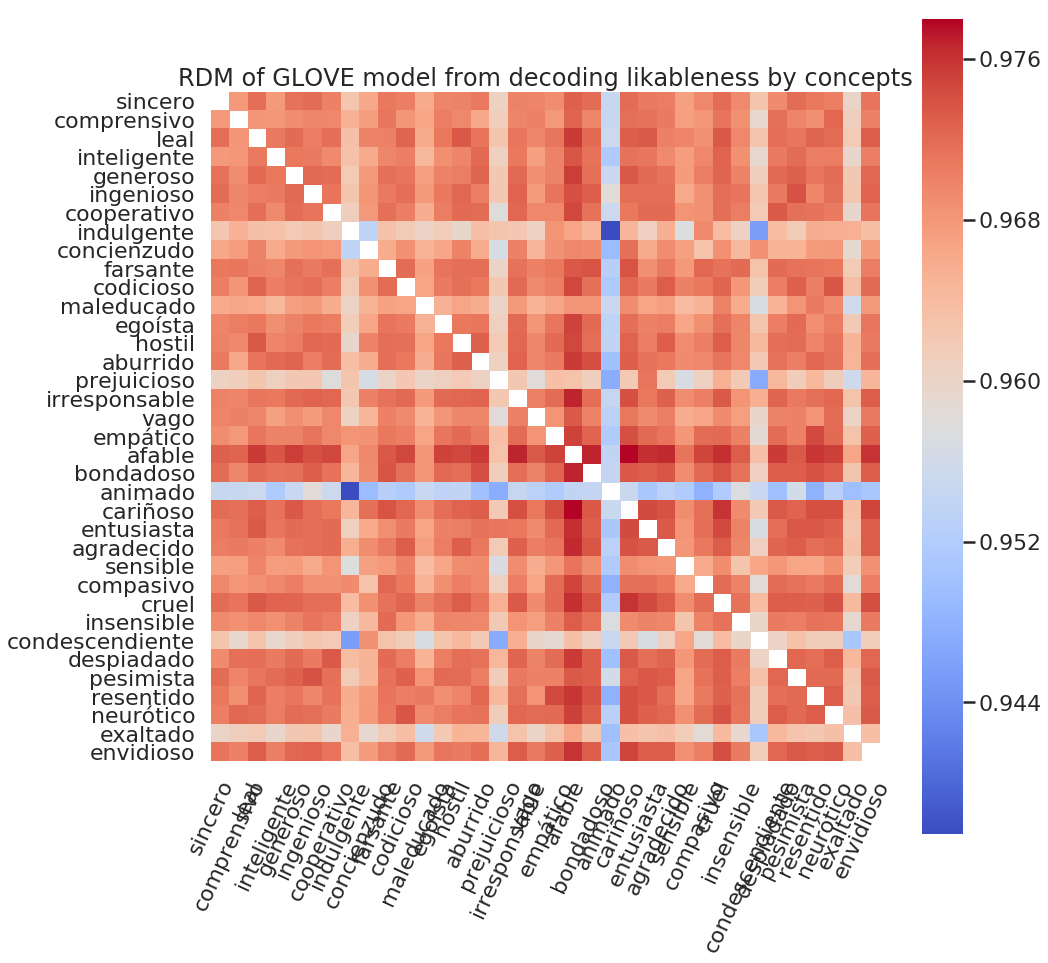

In [17]:
fig,ax = plt.subplots(figsize=(15,15),)
ax = sns.heatmap(cm_likable_mean,
                 cmap = plt.cm.coolwarm,
                 square = True,
                 ax = ax)
ax.set_xticks(np.arange(cm_likable_mean.shape[0]))
#ax.set_xticklabels(np.arange(RDM.shape[0]))
ax.set_xticklabels(word2ticks,rotation = 65)
ax.set_yticklabels(word2ticks,rotation = 0)
ax.set(title='RDM of {} model from decoding likableness by concepts'.format('GLOVE'))

In [18]:
labels = np.array([convert_labels_4(row)for ii,row in stimuli_table.iterrows()])
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
cv = StratifiedShuffleSplit(n_splits,test_size = 0.2,random_state=12345)
scores = []
cm = np.ones((n_splits,features.shape[0],features.shape[0])) * np.nan
for train,test in tqdm(cv.split(features,labels)):
    est = MultiOutputClassifier(CalibratedClassifierCV(LinearSVC(random_state = 12345)))
    clf = make_pipeline(StandardScaler(),
                        est)
    clf.fit(features[train],labels[train])
    preds = np.array(clf.predict_proba(features[test]))[:,:,-1]
    score = [roc_auc_score(a,b) for a,b in zip(labels[test].T,preds)]
    scores.append(score)
    for idx_train in train:
        for idx_test in test:
            cm[idx,idx_train,idx_test] = np.mean(score)
            cm[idx,idx_test,idx_train] = np.mean(score)
cm_mean = np.nanmean(cm,0)
scores = np.array(scores)

3000it [02:56, 17.19it/s]
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:19: RuntimeWarning: Mean of empty slice


[Text(0.5,1,'Decode both Condition and Likableness by the concepts, MultiOutput Classification\nCV = 1000 folds, GLOVE model')]

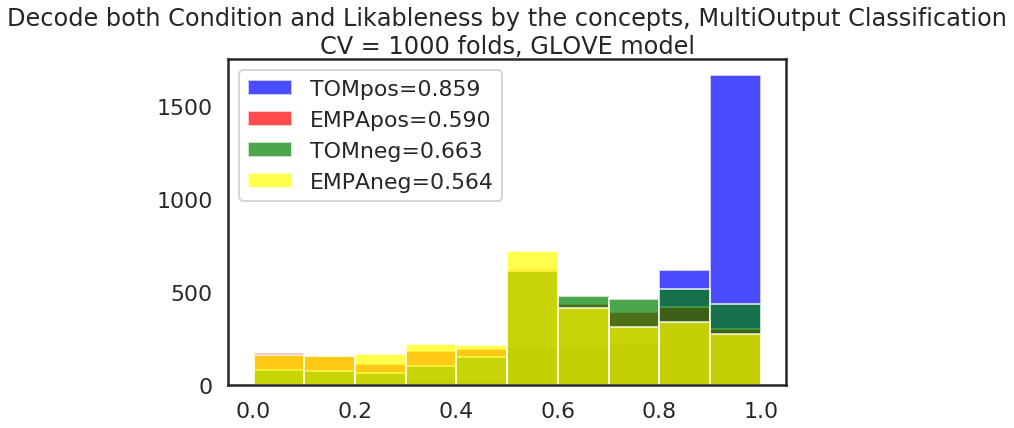

In [19]:
colors = ['blue','red','green','yellow']
classes = ['TOMpos','EMPApos','TOMneg','EMPAneg']
fig,ax = plt.subplots(figsize=(10,6))
for score,color,class_name in zip(scores.T,colors,classes):
    ax.hist(score,color=color,label='{}={:.3f}'.format(class_name,np.mean(score)),alpha=0.7,bins=10)
ax.legend()
ax.set(title = 'Decode both Condition and Likableness by the concepts, MultiOutput Classification\nCV = 1000 folds, {} model'.format('GLOVE'))

In [0]:
from sklearn.multiclass import OneVsOneClassifier
from sklearn.metrics import accuracy_score
from sklearn.dummy import DummyClassifier

In [21]:
labels = np.array([convert_labels_4(row)for ii,row in stimuli_table.iterrows()])
cm = np.ones((n_splits,features.shape[0],features.shape[0])) * np.nan
cv = StratifiedShuffleSplit(n_splits,test_size = 0.2,random_state=12345)
scores = []
chance = []
for idx,(train,test) in tqdm(enumerate(cv.split(features,labels))):
    est = OneVsOneClassifier(LinearSVC(random_state = 12345))
    clf = make_pipeline(StandardScaler(),
                        est)
    clf.fit(features[train],labels[train])
    preds = np.array(clf.predict(features[test]))
    score = accuracy_score(labels[test],preds)
    scores.append(score)
    for idx_train in train:
        for idx_test in test:
            cm[idx,idx_train,idx_test] = score
            cm[idx,idx_test,idx_train] = score
    
    est = OneVsOneClassifier(DummyClassifier())
    clf = make_pipeline(StandardScaler(),
                       est)
    clf.fit(features[train],labels[train])
    preds = np.array(clf.predict(features[test]))
    score = accuracy_score(labels[test],preds)
    chance.append(score)
cm_mean = np.nanmean(cm,0)

3000it [00:54, 54.85it/s]
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: Mean of empty slice


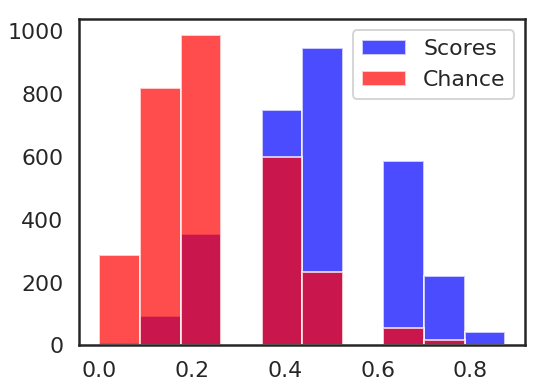

In [22]:
fig,ax = plt.subplots(figsize=(8,6))
ax.hist(scores,color='blue',alpha=0.7,bins=10,label='Scores')
ax.hist(chance,color='red',alpha=0.7,bins=10,label='Chance')
ax.legend()

[Text(0.5,1,'RDM of GLOVE model from decoding by concepts')]

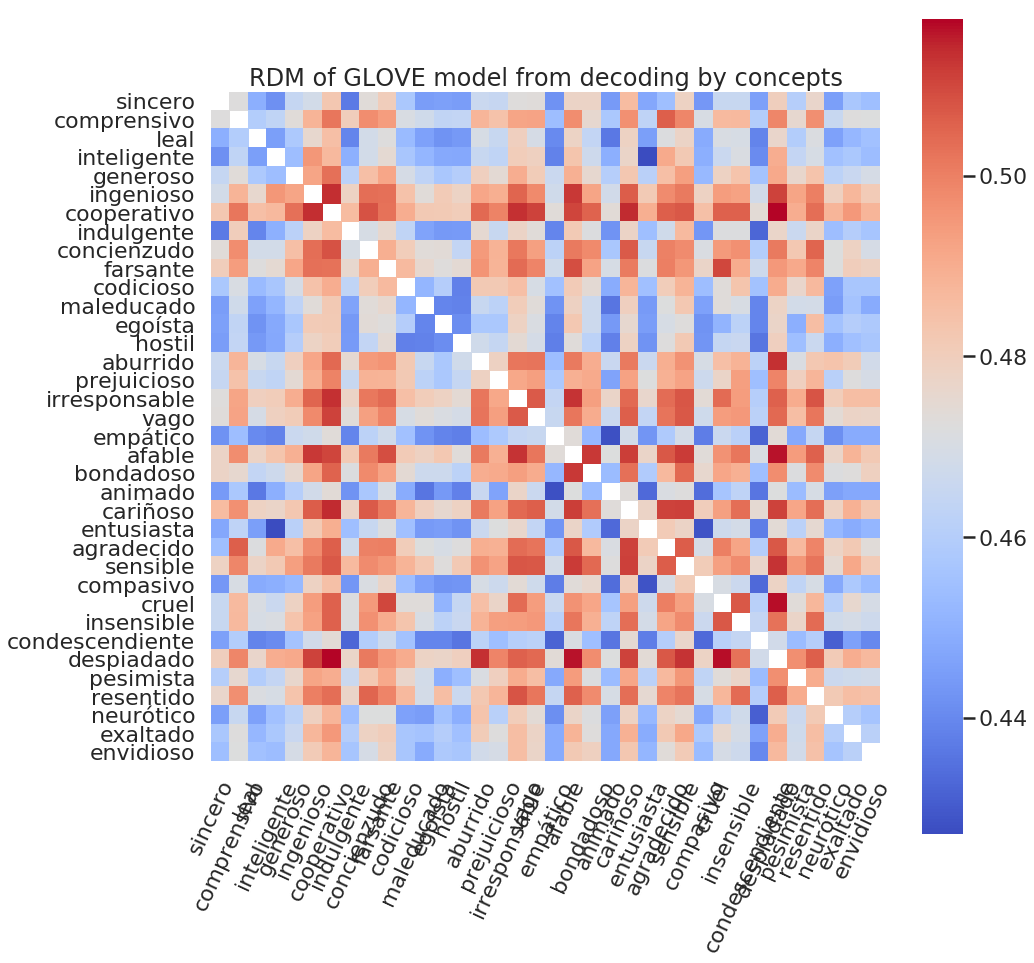

In [23]:
fig,ax = plt.subplots(figsize=(15,15),)
ax = sns.heatmap(cm_mean,
                 cmap = plt.cm.coolwarm,
                 square = True,
                 ax = ax)
ax.set_xticks(np.arange(cm_mean.shape[0]))
#ax.set_xticklabels(np.arange(RDM.shape[0]))
ax.set_xticklabels(word2ticks,rotation = 65)
ax.set_yticklabels(word2ticks,rotation = 0)
ax.set(title='RDM of {} model from decoding by concepts'.format('GLOVE'))

# We can do the same for the definitions, which are sentences

## But instead of looking at all the words, we will compute the average representation over all the words (if the word contains more than 3 letters)

In [0]:
definition = stimuli_table['Definition'].values
word_chosen = []
sentence = []
for item in definition:
    temp_ = []
    temp_word_chosen = []
    for word in item.replace(',','').replace('/a','').split(' '):
        if len(word.decode('utf-8').lower()) > 3:
            temp_.append(model_glove[word.decode('utf-8').lower()])
            temp_word_chosen.append(word.decode('utf-8').lower())
    sentence.append(temp_)
    word_chosen.append(temp_word_chosen)

In [25]:
# decoding the concepts based on the word2vec model of the concepts
from sklearn.preprocessing import LabelBinarizer
lb = LabelBinarizer()
# we want to predict theory of mind
condition = lb.fit_transform(stimuli_table['Condition'].values).flatten()
# we want to predict positive - negative as well
likableness = lb.fit_transform(stimuli_table['Likableness'].values).flatten()
# concatenate these 2 1-D vectors to generate a 2 X n_sample target matrix
labels = np.vstack([condition,likableness]).T
features = np.array([np.mean(item,0) for item in sentence])
cv = StratifiedShuffleSplit(n_splits,test_size = 0.2,random_state=12345)
scores = []
for train,test in tqdm(cv.split(features,labels)):
    est = MultiOutputClassifier(CalibratedClassifierCV(LinearSVC(random_state = 12345)))
    clf = make_pipeline(StandardScaler(),
                        est)
    clf.fit(features[train],labels[train])
    preds = np.array(clf.predict_proba(features[test]))[:,:,-1]
    score = [roc_auc_score(a,b) for a,b in zip(labels[test].T,preds)]
    scores.append(score)
scores = np.array(scores)

3000it [01:26, 34.63it/s]


[Text(0.5,1,'Decode both Condition and Likableness by defnitions, MultiOutput Classification\nCV = 1000 folds, GLOVE model')]

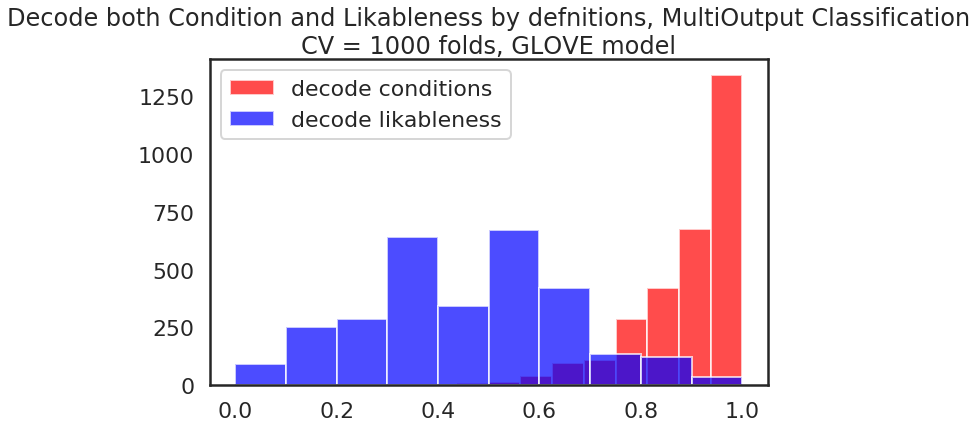

In [26]:
fig,ax = plt.subplots(figsize=(10,6))
ax.hist(scores[:,0],color='red',label='decode conditions',alpha=0.7,bins=10)
ax.hist(scores[:,1],color='blue',label='decode likableness',alpha=0.7,bins=10)
ax.legend()
ax.set(title = 'Decode both Condition and Likableness by defnitions, MultiOutput Classification\nCV = 1000 folds, {} model'.format('GLOVE'))

In [27]:
cm_condition = np.ones((n_splits,features.shape[0],features.shape[0])) * np.nan
cm_likable = np.ones((n_splits,features.shape[0],features.shape[0])) * np.nan
cv = StratifiedShuffleSplit(n_splits,test_size = 0.2,random_state=12345)
for idx,(train,test) in tqdm(enumerate(cv.split(features,labels))):
    est = MultiOutputClassifier(CalibratedClassifierCV(LinearSVC(random_state = 12345)))
    clf = make_pipeline(StandardScaler(),
                        est)
    clf.fit(features[train],labels[train])
    preds = np.array(clf.predict_proba(features[test]))[:,:,-1]
    score = [roc_auc_score(a,b) for a,b in zip(labels[test].T,preds)]
    for idx_train in train:
        for idx_test in test:
            cm_condition[idx,idx_train,idx_test] = score[0]
            cm_condition[idx,idx_test,idx_train] = score[0]
            cm_likable[idx,idx_train,idx_test] = score[1]
            cm_likable[idx,idx_test,idx_train] = score[1]
cm_condition_mean = np.nanmean(cm_condition,0)
#np.fill_diagonal(cm_condition_mean, np.nan)
cm_likable_mean = np.nanmean(cm_likable,0)
#np.fill_diagonal(cm_likable_mean, np.nan)

3000it [01:25, 35.80it/s]
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: Mean of empty slice
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:19: RuntimeWarning: Mean of empty slice


[Text(0.5,1,'RDM of GLOVE model from decoding condition by definitions')]

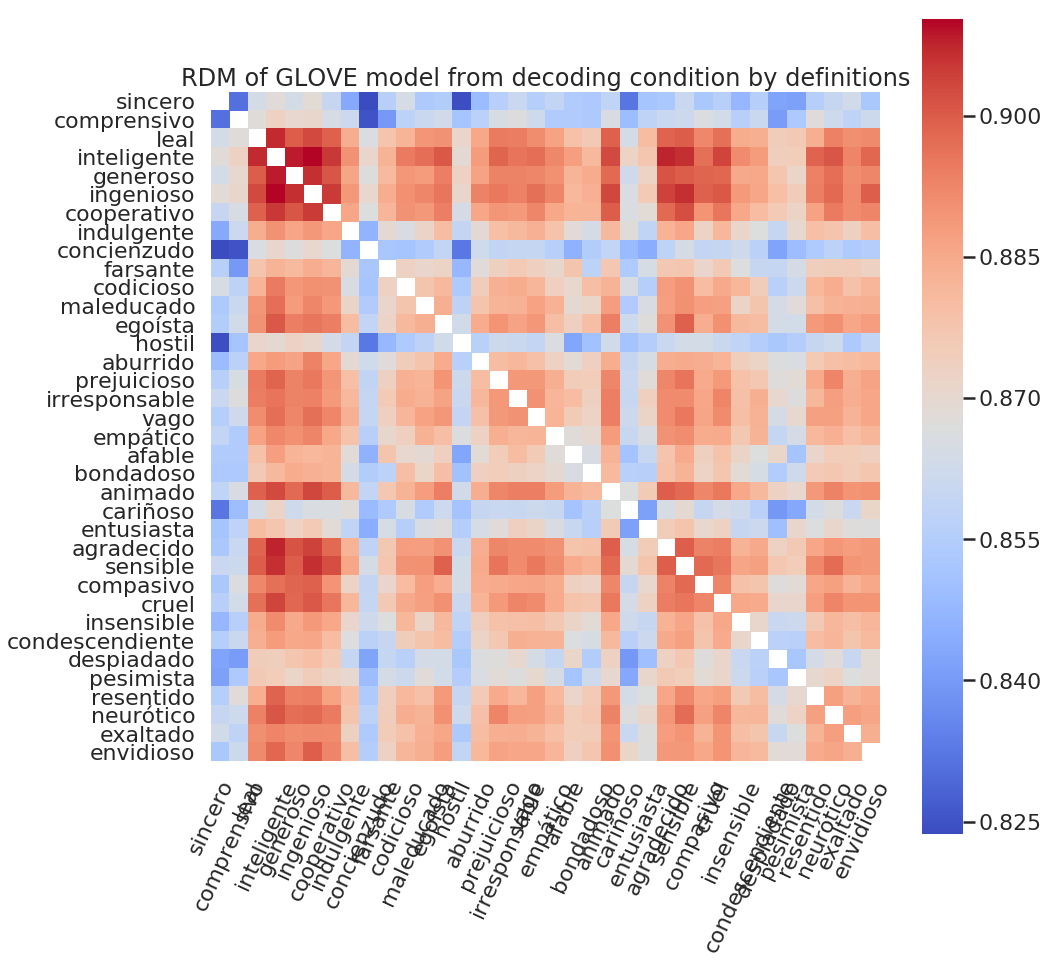

In [28]:
fig,ax = plt.subplots(figsize=(15,15),)
ax = sns.heatmap(cm_condition_mean,
                 cmap = plt.cm.coolwarm,
                 square = True,
                 ax = ax)
ax.set_xticks(np.arange(cm_condition_mean.shape[0]))
#ax.set_xticklabels(np.arange(RDM.shape[0]))
ax.set_xticklabels(word2ticks,rotation = 65)
ax.set_yticklabels(word2ticks,rotation = 0)
ax.set(title='RDM of {} model from decoding condition by definitions'.format('GLOVE'))

[Text(0.5,1,'RDM of GLOVE model from decoding likableness by definition')]

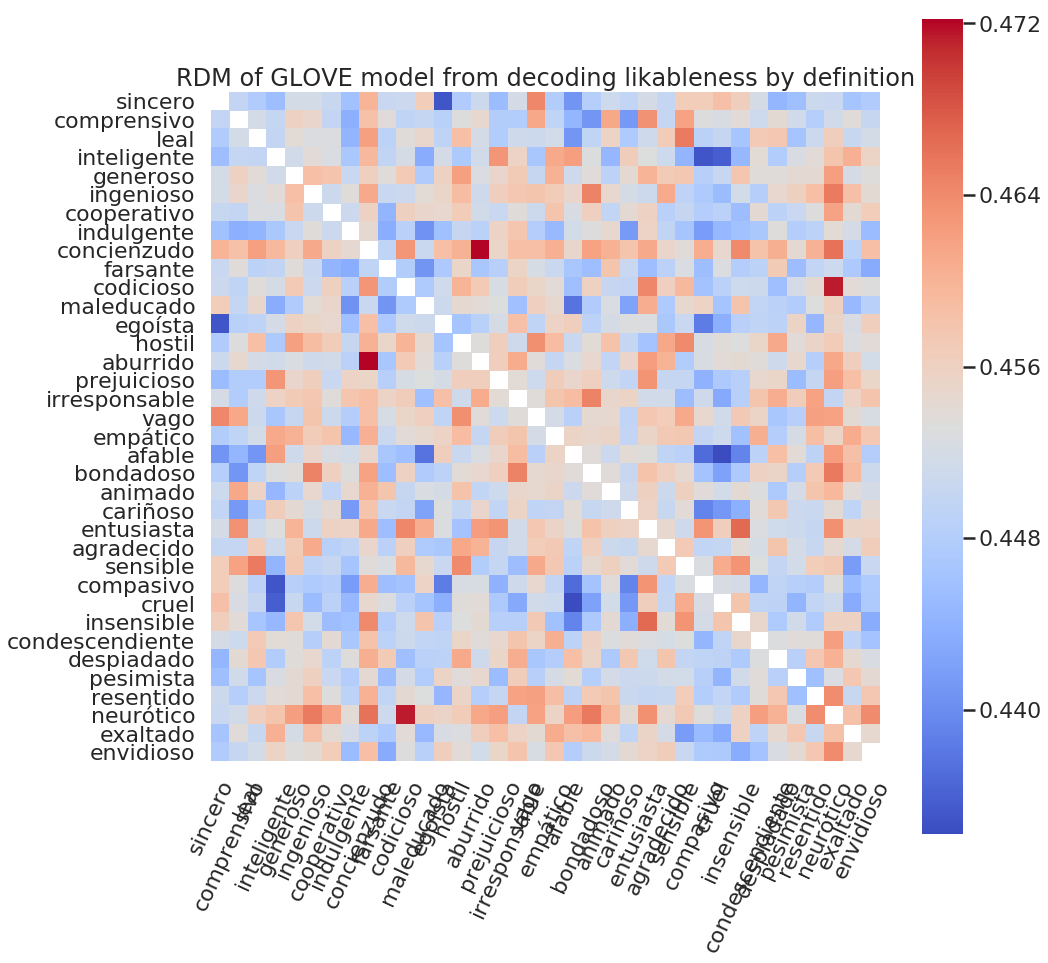

In [29]:
fig,ax = plt.subplots(figsize=(15,15),)
ax = sns.heatmap(cm_likable_mean,
                 cmap = plt.cm.coolwarm,
                 square = True,
                 ax = ax)
ax.set_xticks(np.arange(cm_likable_mean.shape[0]))
#ax.set_xticklabels(np.arange(RDM.shape[0]))
ax.set_xticklabels(word2ticks,rotation = 65)
ax.set_yticklabels(word2ticks,rotation = 0)
ax.set(title='RDM of {} model from decoding likableness by definition'.format('GLOVE'))